In [1]:
import sys
print(sys.version)

3.9.17 (main, Jul  5 2023, 20:41:20) 
[GCC 11.2.0]


In [2]:
#pip install fastai

In [3]:
#pip install efficientnet-pytorch

In [4]:
import fastai
print(fastai.__version__)  # Check the installed version

2.7.18


In [5]:
# Import required libraries
from fastai.vision.all import *
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Input: Image, Target: Category
    get_items=get_image_files,  # Get all image files in the path
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Train/valid split
    get_y=parent_label,  # Labels from parent folder names
    item_tfms=Resize(460),  # Resize to 460 before batching
    batch_tfms=aug_transforms(size=224)  # Resize to 224 with augmentations
)

# Load the DataLoaders
path = Path('data/train15')
dls = dblock.dataloaders(path, bs=8, num_workers=0)

# Show a batch of images
# dls.show_batch(max_n=9, figsize=(8, 8))

In [6]:
class PretrainedEyeDiseaseClassifier(nn.Module):
    def __init__(self, pretrained_model='vgg16', num_classes=5):
        super(PretrainedEyeDiseaseClassifier, self).__init__()
        if pretrained_model == 'vgg16':
            self.model = models.vgg16(pretrained=True)
            self.model.classifier[6] = nn.Linear(4096, num_classes)
        elif pretrained_model == 'resnet18':
            self.model = models.resnet18(pretrained=True)
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, num_classes)
        elif pretrained_model == 'efficientnet-b7':
            self.model = EfficientNet.from_pretrained('efficientnet-b7')
            self.num_ftrs = self.model._fc.in_features
            self.model._fc = nn.Linear(self.num_ftrs, num_classes)
        else:
            raise ValueError('Unsupported pretrained model. Choose vgg16, resnet18 or efficientnet-b7.')

    def forward(self, x):
        return self.model(x)

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Custom precision with zero_division handling for macro average
def precision_macro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return precision_score(targs, preds, average='macro', zero_division=1)

def precision_micro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return precision_score(targs, preds, average='micro', zero_division=1)

# Custom recall with zero_division handling for macro average
def recall_macro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return recall_score(targs, preds, average='macro', zero_division=1)

def recall_micro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return recall_score(targs, preds, average='micro', zero_division=1)

# Custom f1 score with zero_division handling for macro average
def f1score_macro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return f1_score(targs, preds, average='macro', zero_division=1)

def f1score_micro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return f1_score(targs, preds, average='micro', zero_division=1)

In [8]:
# Initialize the Model
model = PretrainedEyeDiseaseClassifier(pretrained_model='efficientnet-b7', num_classes=5)

# Create the Learner
learn = Learner(
    dls,
    model,
    loss_func=CrossEntropyLossFlat(),
    opt_func=partial(Adam, lr=0.001),
    metrics=[
        accuracy,
        precision_micro, recall_micro, f1score_micro,
        precision_macro, recall_macro, f1score_macro
    ]
)

# Train the Model
learn.fine_tune(10)  # Train for 10 epochs

Loaded pretrained weights for efficientnet-b7


epoch,train_loss,valid_loss,accuracy,precision_micro,recall_micro,f1score_micro,precision_macro,recall_macro,f1score_macro,time
0,0.719790,0.675646,0.773096,0.773096,0.773096,0.773096,0.788009,0.602114,0.489233,2:20:20
1,0.654295,0.607669,0.806690,0.806690,0.806690,0.806690,0.862603,0.613851,0.551642,2:16:50
2,0.656313,0.651530,0.799288,0.799288,0.799288,0.799288,0.867231,0.586989,0.529713,2:16:52
3,0.621377,0.568583,0.816797,0.816797,0.816797,0.816797,0.852722,0.647935,0.577781,2:20:23
4,0.647587,0.588064,0.806975,0.806975,0.806975,0.806975,0.856533,0.624636,0.544851,2:20:15
5,0.609105,0.607456,0.812527,0.812527,0.812527,0.812527,0.869571,0.619057,0.557823,2:20:55
6,0.609253,0.543741,0.827900,0.827900,0.827900,0.827900,0.851490,0.677585,0.596812,2:25:07
7,0.560554,0.622768,0.809253,0.809253,0.809253,0.809253,0.856300,0.629871,0.549099,2:22:48
8,0.583820,0.577874,0.816512,0.816512,0.816512,0.816512,0.869675,0.629540,0.574572,2:25:30
9,0.540261,0.540244,0.829466,0.829466,0.829466,0.829466,0.866435,0.661268,0.599371,2:26:50


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



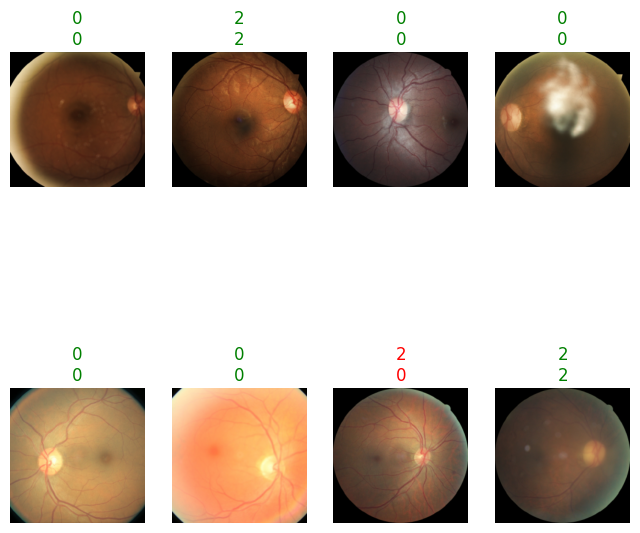

In [9]:
learn.show_results(max_n=9, figsize=(8, 8))

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Custom function to generate a report after training
def evaluate_model(learner, dl):
    preds, targs = learner.get_preds(dl=dl)
    preds = preds.argmax(dim=1).cpu().numpy()
    targets = targs.cpu().numpy()

    # Accuracy
    acc = accuracy_score(targets, preds)
    print(f"Accuracy: {acc:.4f}")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(targets, preds, zero_division=1))
    
    # Confusion Matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(targets, preds))
    
    micro_precision = precision_score(targets, preds, average='micro')
    micro_recall = recall_score(targets, preds, average='micro')
    micro_f1 = f1_score(targets, preds, average='micro')

    macro_precision = precision_score(targets, preds, average='macro')
    macro_recall = recall_score(targets, preds, average='macro')
    macro_f1 = f1_score(targets, preds, average='macro')

    print("\nMicro and Macro Averages:")
    print(f"Micro Precision: {micro_precision:.4f}")
    print(f"Micro Recall: {micro_recall:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall: {macro_recall:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")

# Call this function after training, passing the validation dataloader
evaluate_model(learn, dls.valid)

Accuracy: 0.8295

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      5209
           1       0.44      0.03      0.06       469
           2       0.68      0.59      0.63      1059
           3       0.71      0.03      0.06       173
           4       0.82      0.31      0.45       115

    accuracy                           0.83      7025
   macro avg       0.70      0.39      0.42      7025
weighted avg       0.80      0.83      0.79      7025


Confusion Matrix:
[[5143   12   50    0    4]
 [ 402   16   51    0    0]
 [ 422    8  627    0    2]
 [  19    0  147    5    2]
 [  30    0   47    2   36]]

Micro and Macro Averages:
Micro Precision: 0.8295
Micro Recall: 0.8295
Micro F1 Score: 0.8295
Macro Precision: 0.7024
Macro Recall: 0.3911
Macro F1 Score: 0.4242


In [11]:
# Save the state_dict (model parameters)
torch.save(model, "models/v4.4_efficientnet-b7_model.pkl")